# Fine-tuning Pre-trained Model for Perturbation Prediction

In [1]:
import json
import os
import sys
import time
import copy
from pathlib import Path
from typing import Iterable, List, Tuple, Dict, Union, Optional
import warnings

import torch
import numpy as np
import matplotlib
from torch import nn
from torch.nn import functional as F
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from torch_geometric.loader import DataLoader
from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.model import TransformerGenerator
from scgpt.loss import (
    masked_mse_loss,
    criterion_neg_log_bernoulli,
    masked_relative_error,
)
from scgpt.tokenizer import tokenize_batch, pad_batch, tokenize_and_pad_batch
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed, map_raw_id_to_vocab_id, compute_perturbation_metrics

matplotlib.rcParams["savefig.transparent"] = False
warnings.filterwarnings("ignore")

set_seed(42)


/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## Training Settings

In [2]:
# settings for data prcocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
pad_value = 0  # for padding values
pert_pad_id = 0
include_zero_gene = "all"
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
amp = True
load_model = "../save/scGPT_human"
load_param_prefixs = [
    "encoder",
    "value_encoder",
    "transformer_encoder",
]

# settings for optimizer
lr = 1e-4  # or 1e-4
batch_size = 64
eval_batch_size = 64
epochs = 3
schedule_interval = 1
early_stop = 10

# settings for the model
embsize = 512  # embedding dimension
d_hid = 512  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # number of heads in nn.MultiheadAttention
n_layers_cls = 3
dropout = 0  # dropout probability
use_fast_transformer = True  # whether to use fast transformer

# logging
log_interval = 100

# dataset and evaluation choices
data_name = "norman"
split = "simulation"
if data_name == "norman":
    perts_to_plot = ['CBL+PTPN9',
                       'DUSP9+PRTG',
                       'FOXL2+MEIS1',
                       'CEBPB+OSR2',
                       'JUN+CEBPB',
                       'CDKN1C+CDKN1B',
                       'CDKN1C+CDKN1A',
                       'CDKN1B+CDKN1A',
                       'C3orf72+FOXL2']
    perts_to_plot_seen = ['ETS2+MAP7D1',
                       'FEV+CBFA2T3',
                       'FOSB+IKZF3',
                       'FOSB+PTPN12',
                       'TGFBR2+ETS2']
elif data_name == "adamson":
    perts_to_plot = ["KCTD16+ctrl"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
save_dir = Path(f"./save/dev_perturb_{data_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"saving to {save_dir}")

logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")
# log running date and current git commit
logger.info(f"Running on {time.strftime('%Y-%m-%d %H:%M:%S')}")

saving to save/dev_perturb_norman-Sep20-07-54
scGPT - INFO - Running on 2024-09-20 07:54:26


In [4]:
pert_data = PertData("./data_scGPT/")
pert_data.load(data_name=data_name)
pert_data.prepare_split(split=split, seed=1)
pert_data.get_dataloader(batch_size=batch_size, test_batch_size=eval_batch_size)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!
Creating dataloaders....
Done!


In [5]:
if load_model is not None:
    model_dir = Path(load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    pert_data.adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in pert_data.adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(pert_data.adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    genes = pert_data.adata.var["gene_name"].tolist()

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    genes = pert_data.adata.var["gene_name"].tolist()
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(
    [vocab[gene] if gene in vocab else vocab["<pad>"] for gene in genes], dtype=int
)
n_genes = len(genes)



scGPT - INFO - match 4547/5045 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


 # Create and train scGpt

In [13]:
ntokens = len(vocab)  # size of vocabulary
model = TransformerGenerator(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=n_layers_cls,
    n_cls=1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=use_fast_transformer,
)
if load_param_prefixs is not None and load_model is not None:
    # only load params that start with the prefix
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if any([k.startswith(prefix) for prefix in load_param_prefixs])
    }
    for k, v in pretrained_dict.items():
        logger.info(f"Loading params {k} with shape {v.shape}")
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
elif load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
model.to(device)

scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.Wqkv.bias with shape torch.Size([153

TransformerGenerator(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (pert_encoder): Embedding(3, 512, padding_idx=0)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=F

In [14]:
criterion = masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, schedule_interval, gamma=0.9)
scaler = torch.cuda.amp.GradScaler(enabled=amp)


def train(model: nn.Module, train_loader: torch.utils.data.DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse = 0.0, 0.0
    start_time = time.time()

    num_batches = len(train_loader)
    for batch, batch_data in enumerate(train_loader):
        batch_size = len(batch_data.y)
        batch_data.to(device)
        x: torch.Tensor = batch_data.x  # (batch_size * n_genes, 2)
        
        ori_gene_values = x[:, 0].view(batch_size, n_genes)
        pert_flags = x[:, 1].long().view(batch_size, n_genes)
        target_gene_values = batch_data.y  # (batch_size, n_genes)

        if include_zero_gene in ["all", "batch-wise"]:
            if include_zero_gene == "all":
                input_gene_ids = torch.arange(n_genes, device=device, dtype=torch.long)
            else:
                input_gene_ids = (
                    ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]
                )
            # sample input_gene_id
            if len(input_gene_ids) > max_seq_len:
                input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[
                    :max_seq_len
                ]
            input_values = ori_gene_values[:, input_gene_ids]
            input_pert_flags = pert_flags[:, input_gene_ids]
            target_values = target_gene_values[:, input_gene_ids]

            mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
            mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)

            # src_key_padding_mask = mapped_input_gene_ids.eq(vocab[pad_token])
            src_key_padding_mask = torch.zeros_like(
                input_values, dtype=torch.bool, device=device
            )

        with torch.cuda.amp.autocast(enabled=amp):
            output_dict = model(
                mapped_input_gene_ids,
                input_values,
                input_pert_flags,
                src_key_padding_mask=src_key_padding_mask,
                CLS=CLS,
                CCE=CCE,
                MVC=MVC,
                ECS=ECS,
            )
            output_values = output_dict["mlm_output"]

            masked_positions = torch.ones_like(
                input_values, dtype=torch.bool
            )  # Use all
            loss = loss_mse = criterion(output_values, target_values, masked_positions)

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        # torch.cuda.empty_cache()

        total_loss += loss.item()
        total_mse += loss_mse.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | mse {cur_mse:5.4f} |"
            )
            total_loss = 0
            total_mse = 0
            start_time = time.time()


def eval_perturb(
    loader: DataLoader, model: TransformerGenerator, device: torch.device
) -> Dict:
    """
    Run model in inference mode using a given data loader
    """

    model.eval()
    model.to(device)
    pert_cat = []
    pred = []
    truth = []
    pred_de = []
    truth_de = []
    results = {}
    logvar = []

    for itr, batch in enumerate(loader):
        batch.to(device)
        pert_cat.extend(batch.pert)
        
        
        with torch.no_grad():
            p = model.pred_perturb(
                batch,
                include_zero_gene=include_zero_gene,
                gene_ids=gene_ids,
            )
            t = batch.y
            pred.extend(p.cpu())
            truth.extend(t.cpu())

            # Differentially expressed genes
            for itr, de_idx in enumerate(batch.de_idx):
                pred_de.append(p[itr, de_idx])
                truth_de.append(t[itr, de_idx])

    # all genes
    results["pert_cat"] = np.array(pert_cat)
    pred = torch.stack(pred)
    truth = torch.stack(truth)
    results["pred"] = pred.detach().cpu().numpy().astype(float)
    results["truth"] = truth.detach().cpu().numpy().astype(float)

    pred_de = torch.stack(pred_de)
    truth_de = torch.stack(truth_de)
    results["pred_de"] = pred_de.detach().cpu().numpy().astype(float)
    results["truth_de"] = truth_de.detach().cpu().numpy().astype(float)

    return results

In [21]:
??compute_perturbation_metrics

Signature:
compute_perturbation_metrics(
    results: Dict,
    ctrl_adata: anndata._core.anndata.AnnData,
    non_zero_genes: bool = False,
    return_raw: bool = False,
) -> Dict
Source:   
def compute_perturbation_metrics(
    results: Dict,
    ctrl_adata: AnnData,
    non_zero_genes: bool = False,
    return_raw: bool = False,
) -> Dict:
    """
    Given results from a model run and the ground truth, compute metrics

    Args:
        results (:obj:`Dict`): The results from a model run
        ctrl_adata (:obj:`AnnData`): The adata of the control condtion
        non_zero_genes (:obj:`bool`, optional): Whether to only consider non-zero
            genes in the ground truth when computing metrics
        return_raw (:obj:`bool`, optional): Whether to return the raw metrics or
            the mean of the metrics. Default is False.

    Returns:
        :obj:`Dict`: The metrics computed
    """
    from scipy.stats import pearsonr

    # metrics:
    #   Pearson correlation of expre

In [15]:
best_val_loss = float("inf")
best_val_corr = 0
best_model = None
patience = 0

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_loader = pert_data.dataloader["train_loader"]
    valid_loader = pert_data.dataloader["val_loader"]

    train(
        model,
        train_loader,
    )

    val_res = eval_perturb(valid_loader, model, device)
    val_metrics = compute_perturbation_metrics(
        val_res, pert_data.adata[pert_data.adata.obs["condition"] == "ctrl"]
    )
    logger.info(f"val_metrics at epoch {epoch}: ")
    logger.info(val_metrics)

    elapsed = time.time() - epoch_start_time
    logger.info(f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | ")

    val_score = val_metrics["pearson"]
    if val_score > best_val_corr:
        best_val_corr = val_score
        best_model = copy.deepcopy(model)
        logger.info(f"Best model with score {val_score:5.4f}")
        patience = 0
    else:
        patience += 1
        if patience >= early_stop:
            logger.info(f"Early stop at epoch {epoch}")
            break

    # torch.save(
    #     model.state_dict(),
    #     save_dir / f"model_{epoch}.pt",
    # )

    scheduler.step()

scGPT - INFO - | epoch   1 | 100/801 batches | lr 0.0001 | ms/batch 326.75 | loss  0.05 | mse 0.0520 |
scGPT - INFO - | epoch   1 | 200/801 batches | lr 0.0001 | ms/batch 322.92 | loss  0.04 | mse 0.0421 |
scGPT - INFO - | epoch   1 | 300/801 batches | lr 0.0001 | ms/batch 322.97 | loss  0.04 | mse 0.0422 |
scGPT - INFO - | epoch   1 | 400/801 batches | lr 0.0001 | ms/batch 323.02 | loss  0.04 | mse 0.0412 |
scGPT - INFO - | epoch   1 | 500/801 batches | lr 0.0001 | ms/batch 322.88 | loss  0.04 | mse 0.0413 |
scGPT - INFO - | epoch   1 | 600/801 batches | lr 0.0001 | ms/batch 323.10 | loss  0.04 | mse 0.0407 |
scGPT - INFO - | epoch   1 | 700/801 batches | lr 0.0001 | ms/batch 322.94 | loss  0.04 | mse 0.0411 |
scGPT - INFO - | epoch   1 | 800/801 batches | lr 0.0001 | ms/batch 323.06 | loss  0.04 | mse 0.0412 |
scGPT - INFO - val_metrics at epoch 1: 
scGPT - INFO - {'pearson': 0.9874034520597232, 'pearson_de': 0.8938595075788094, 'pearson_delta': 0.3934209778829621, 'pearson_de_delta'

In [16]:
torch.save(best_model.state_dict(), save_dir / "best_model_3epoch.pt")

 ## Evaluations

In [48]:
pert_data.subgroup

{'test_subgroup': {'combo_seen0': ['CBL+PTPN9',
   'DUSP9+PRTG',
   'FOXL2+MEIS1',
   'CEBPB+OSR2',
   'JUN+CEBPB',
   'CDKN1C+CDKN1B',
   'CDKN1C+CDKN1A',
   'CDKN1B+CDKN1A',
   'C3orf72+FOXL2'],
  'combo_seen1': ['MAP2K6+SPI1',
   'DUSP9+MAPK1',
   'UBASH3B+OSR2',
   'DUSP9+ETS2',
   'ZNF318+FOXL2',
   'UBASH3B+PTPN9',
   'JUN+CEBPA',
   'MAPK1+PRTG',
   'KLF1+COL2A1',
   'PTPN12+OSR2',
   'POU3F2+FOXL2',
   'BCL2L11+TGFBR2',
   'CEBPB+CEBPA',
   'PTPN12+PTPN9',
   'FOSB+CEBPB',
   'BCL2L11+BAK1',
   'CBL+CNN1',
   'ZBTB10+PTPN12',
   'CBL+UBASH3B',
   'CEBPB+PTPN12',
   'CEBPB+MAPK1',
   'DUSP9+IGDCC3',
   'CBL+PTPN12',
   'SGK1+S1PR2',
   'DUSP9+KLF1',
   'CEBPE+SPI1',
   'CBL+TGFBR2',
   'FOXA1+FOXL2',
   'FOXF1+FOXL2',
   'ETS2+PRTG',
   'LYL1+CEBPB',
   'DUSP9+SNAI1',
   'TGFBR2+PRTG',
   'FOSB+OSR2',
   'FOXL2+HOXB9',
   'ZBTB10+ELMSAN1',
   'ZBTB10+SNAI1',
   'CEBPE+CEBPB',
   'PRDM1+CBFA2T3',
   'FOXA3+FOXL2',
   'ZBTB10+DLX2',
   'CBL+UBASH3A',
   'IGDCC3+PRTG'],
  'combo_se

In [17]:
def predict(
    model: TransformerGenerator, pert_list: List[str], pool_size: Optional[int] = None
) -> Dict:
    """
    Predict the gene expression values for the given perturbations.

    Args:
        model (:class:`torch.nn.Module`): The model to use for prediction.
        pert_list (:obj:`List[str]`): The list of perturbations to predict.
        pool_size (:obj:`int`, optional): For each perturbation, use this number
            of cells in the control and predict their perturbation results. Report
            the stats of these predictions. If `None`, use all control cells.
    """
    adata = pert_data.adata
    ctrl_adata = adata[adata.obs["condition"] == "ctrl"]
    if pool_size is None:
        pool_size = len(ctrl_adata.obs)
    gene_list = pert_data.gene_names.values.tolist()
    for pert in pert_list:
        for i in pert:
            if i not in gene_list:
                raise ValueError(
                    "The gene is not in the perturbation graph. Please select from GEARS.gene_list!"
                )

    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        results_pred = {}
        for pert in pert_list:
            cell_graphs = create_cell_graph_dataset_for_prediction(
                pert, ctrl_adata, gene_list, device, num_samples=pool_size
            )
            loader = DataLoader(cell_graphs, batch_size=eval_batch_size, shuffle=False)
            
            #global test
            #test = loader
            
            preds = []
            for batch_data in loader:
                pred_gene_values = model.pred_perturb(
                    batch_data, include_zero_gene, gene_ids=gene_ids, amp=amp
                )
                preds.append(pred_gene_values)
            preds = torch.cat(preds, dim=0)
            results_pred["_".join(pert)] = np.mean(preds.detach().cpu().numpy(), axis=0)

    return results_pred



In [18]:
def plot_perturbation(
    model: nn.Module, query: str, save_file: str = None, pool_size: int = None
) -> matplotlib.figure.Figure:
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

    adata = pert_data.adata
    gene2idx = pert_data.node_map
    cond2name = dict(adata.obs[["condition", "condition_name"]].values)
    gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

    de_idx = [
        gene2idx[gene_raw2id[i]]
        for i in adata.uns["top_non_dropout_de_20"][cond2name[query]]
    ]
    genes = [
        gene_raw2id[i] for i in adata.uns["top_non_dropout_de_20"][cond2name[query]]
    ]
    truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]
    if query.split("+")[1] == "ctrl":
        pred = predict(model, [[query.split("+")[0]]], pool_size=pool_size)
        pred = pred[query.split("+")[0]][de_idx]
    else:
        pred = predict(model, [query.split("+")], pool_size=pool_size)
        pred = pred["_".join(query.split("+"))][de_idx]
    ctrl_means = adata[adata.obs["condition"] == "ctrl"].to_df().mean()[de_idx].values

    pred = pred - ctrl_means
    truth = truth - ctrl_means

    fig, ax = plt.subplots(figsize=[16.5, 4.5])
    plt.title(query)
    plt.boxplot(truth, showfliers=False, medianprops=dict(linewidth=0))

    for i in range(pred.shape[0]):
        _ = plt.scatter(i + 1, pred[i], color="red")

    plt.axhline(0, linestyle="dashed", color="green")

    ax.xaxis.set_ticklabels(genes, rotation=90)

    plt.ylabel("Change in Gene Expression over Control", labelpad=10)
    plt.tick_params(axis="x", which="major", pad=5)
    plt.tick_params(axis="y", which="major", pad=5)
    sns.despine()

    if save_file:
        fig.savefig(save_file, bbox_inches="tight", transparent=False)

    return fig

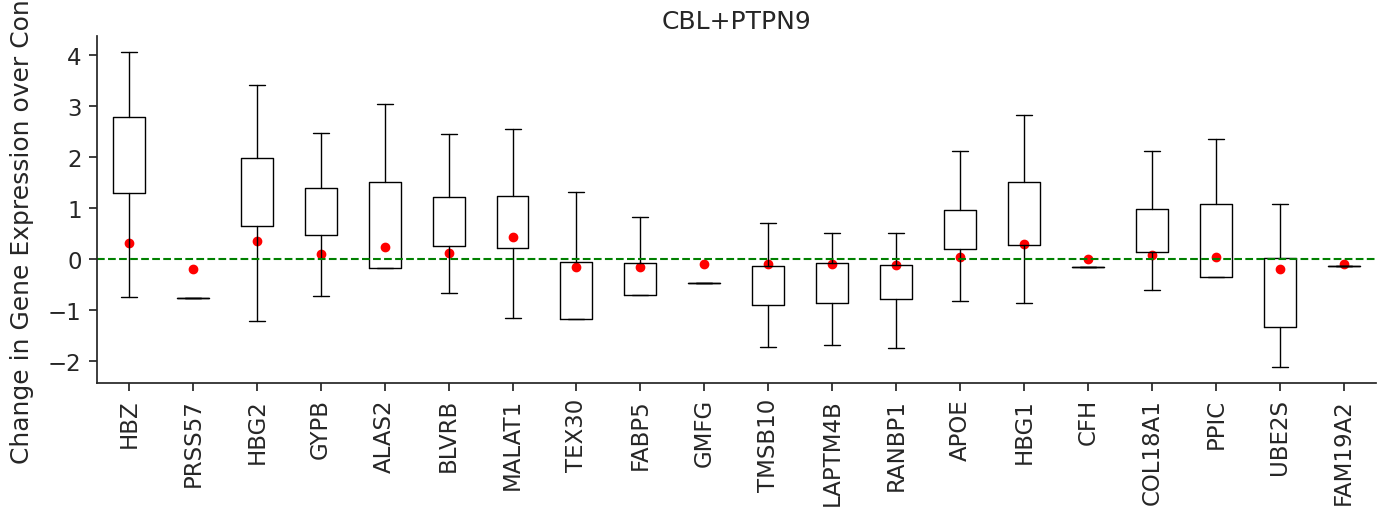

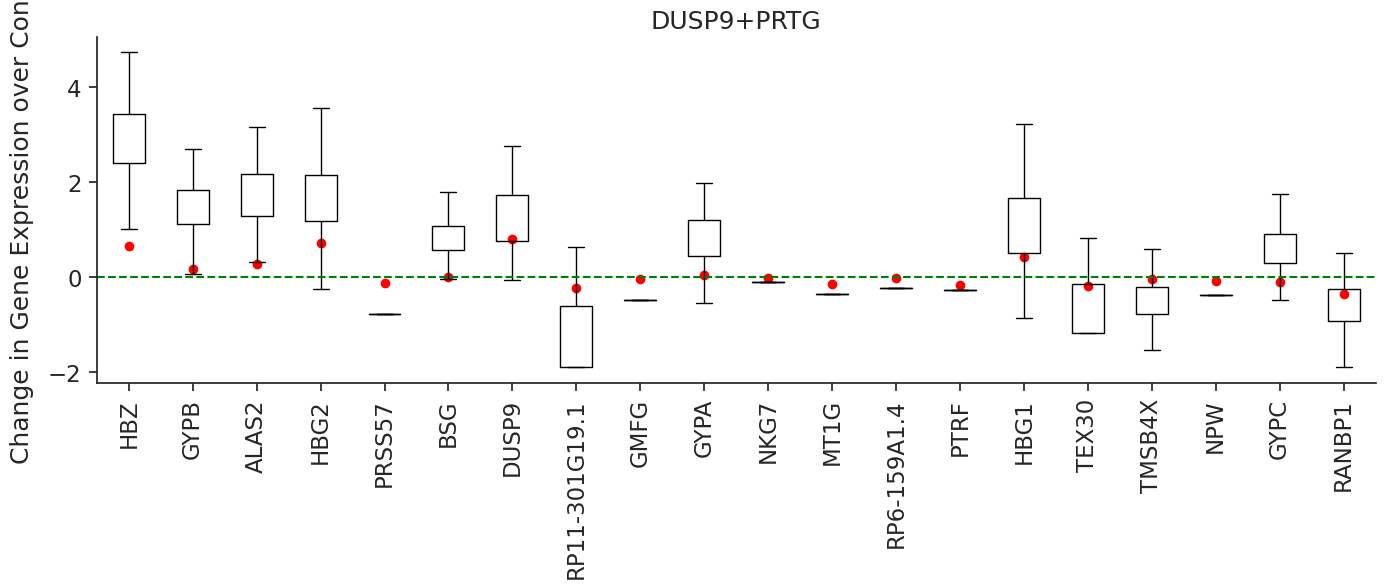

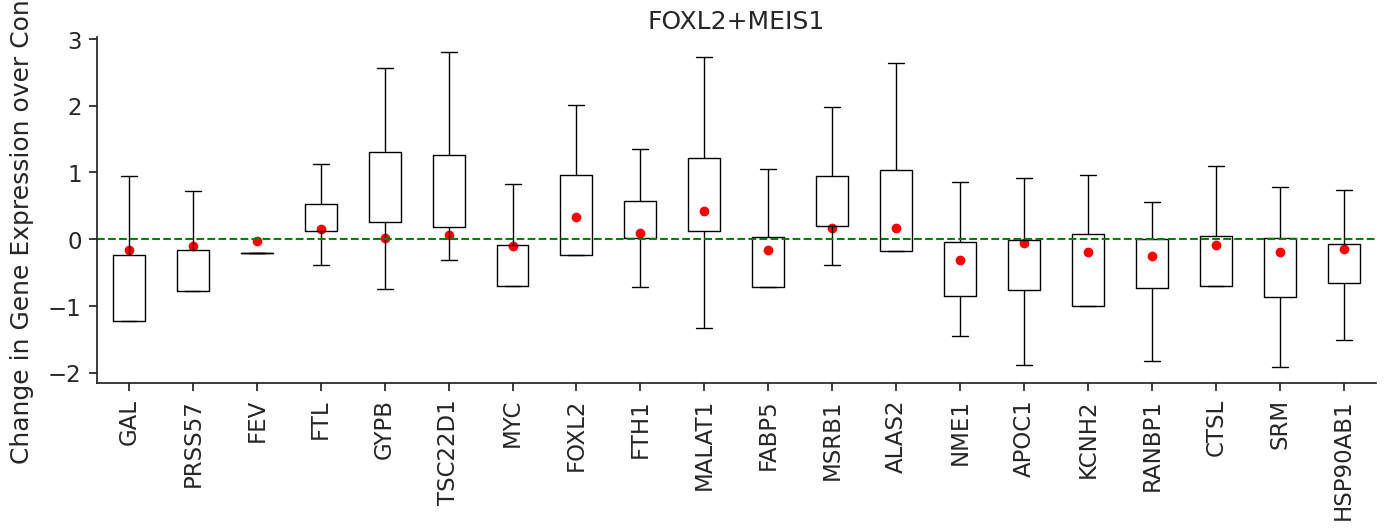

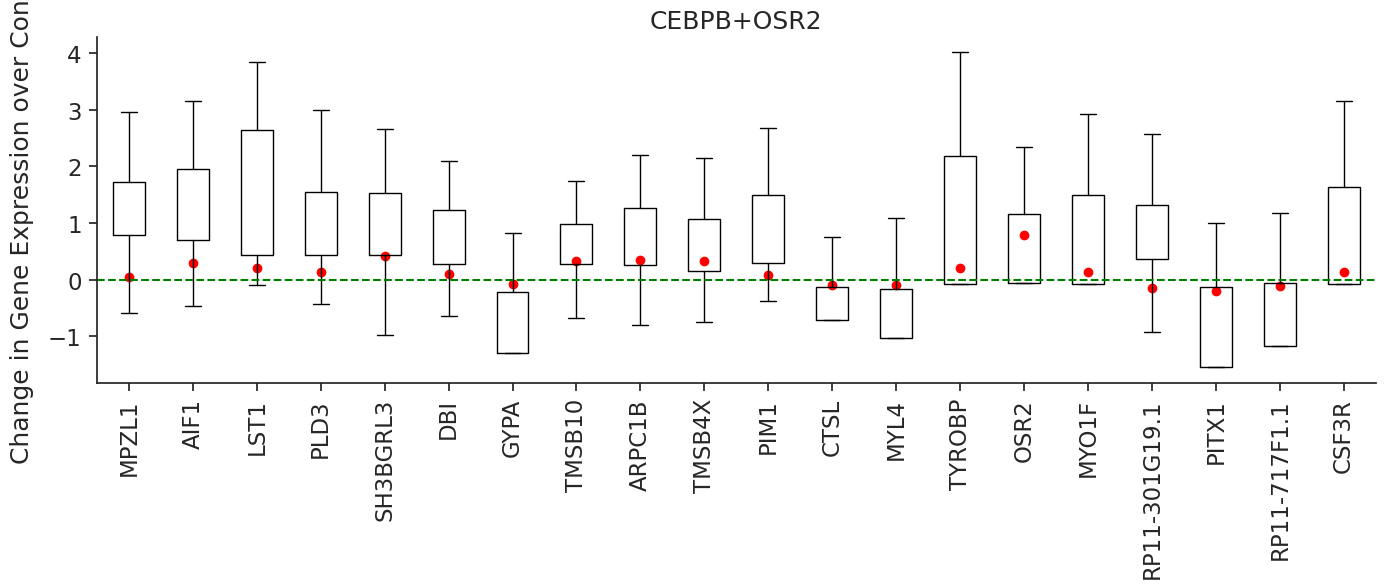

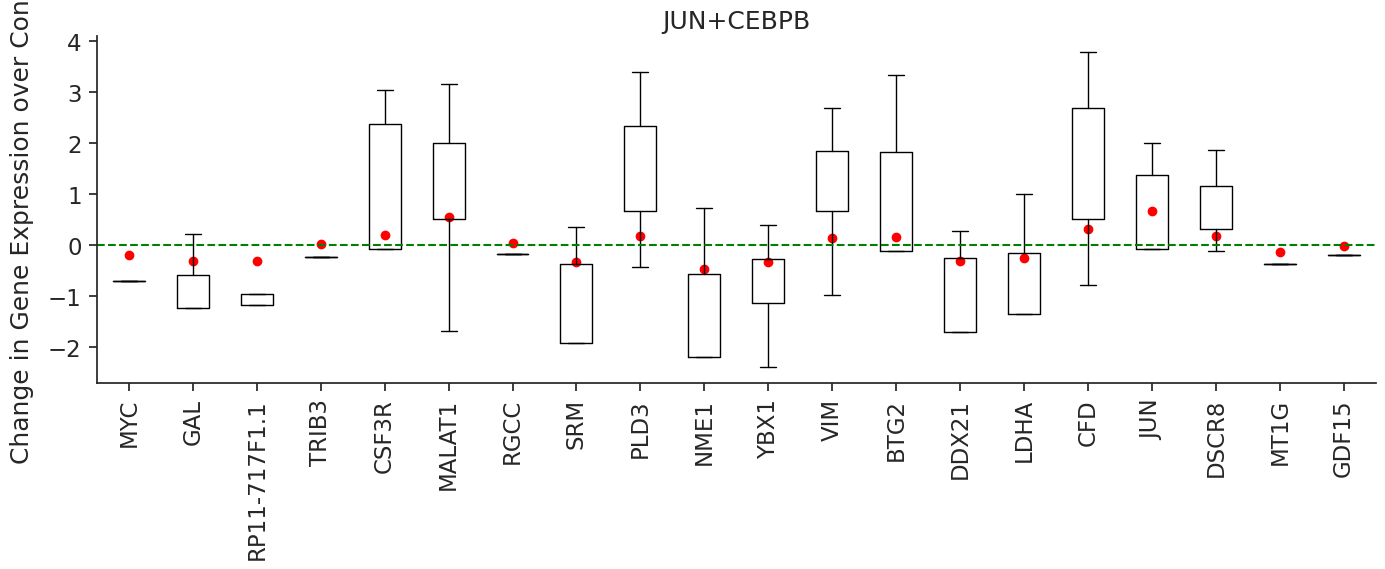

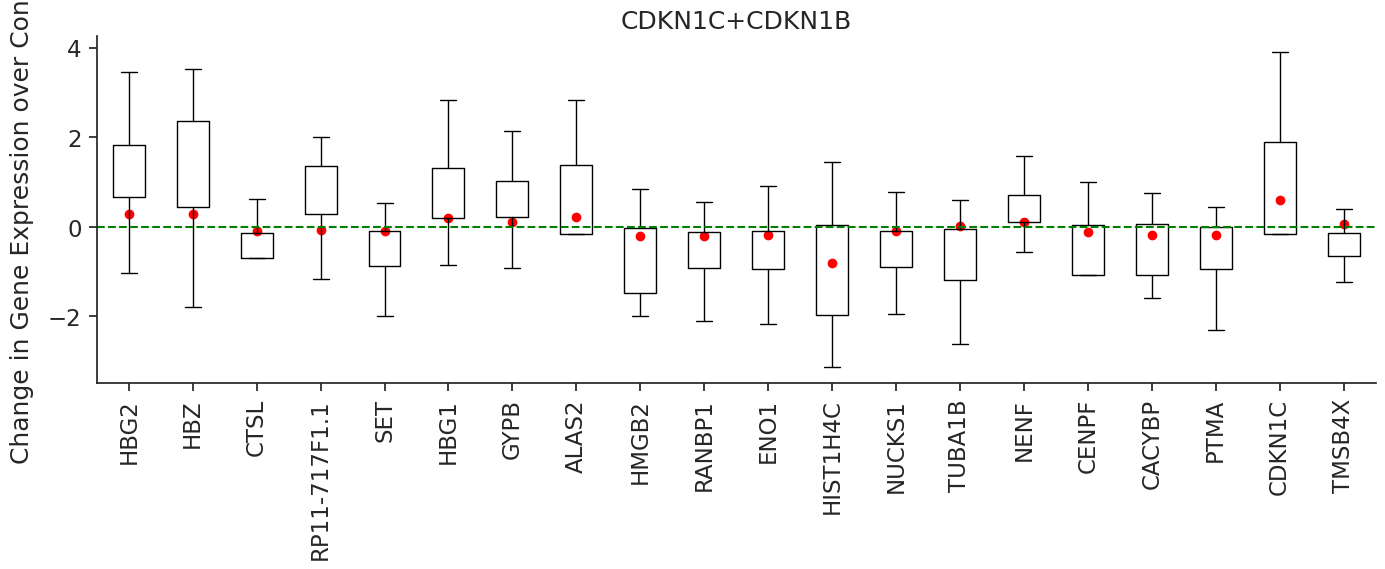

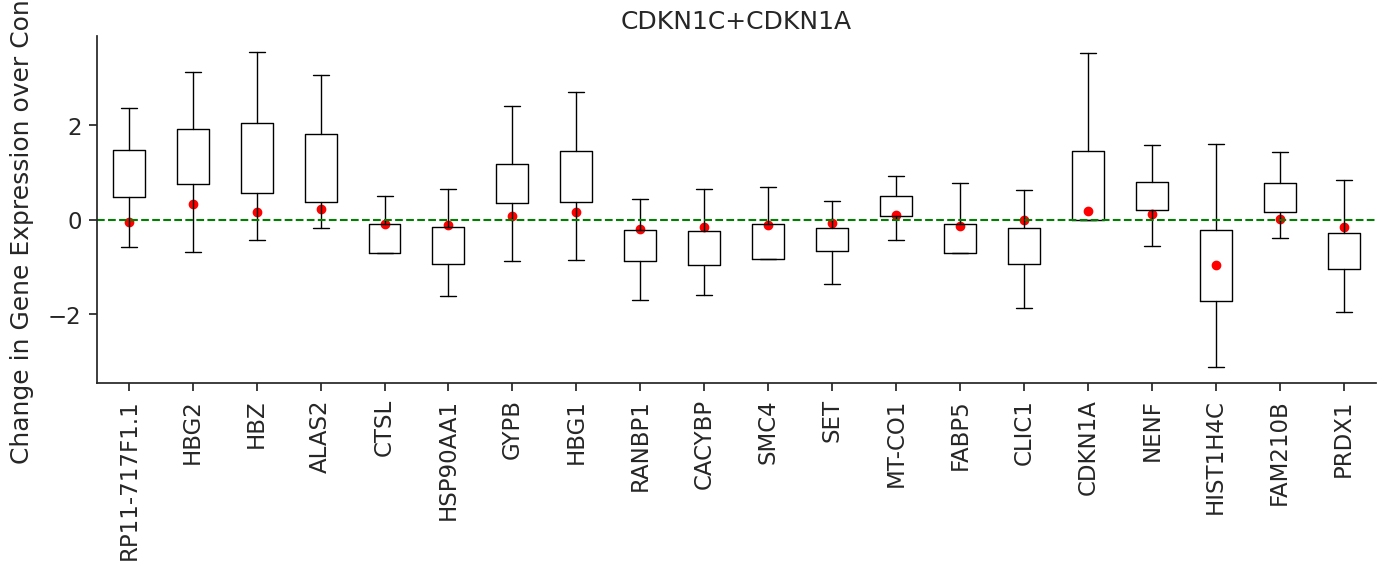

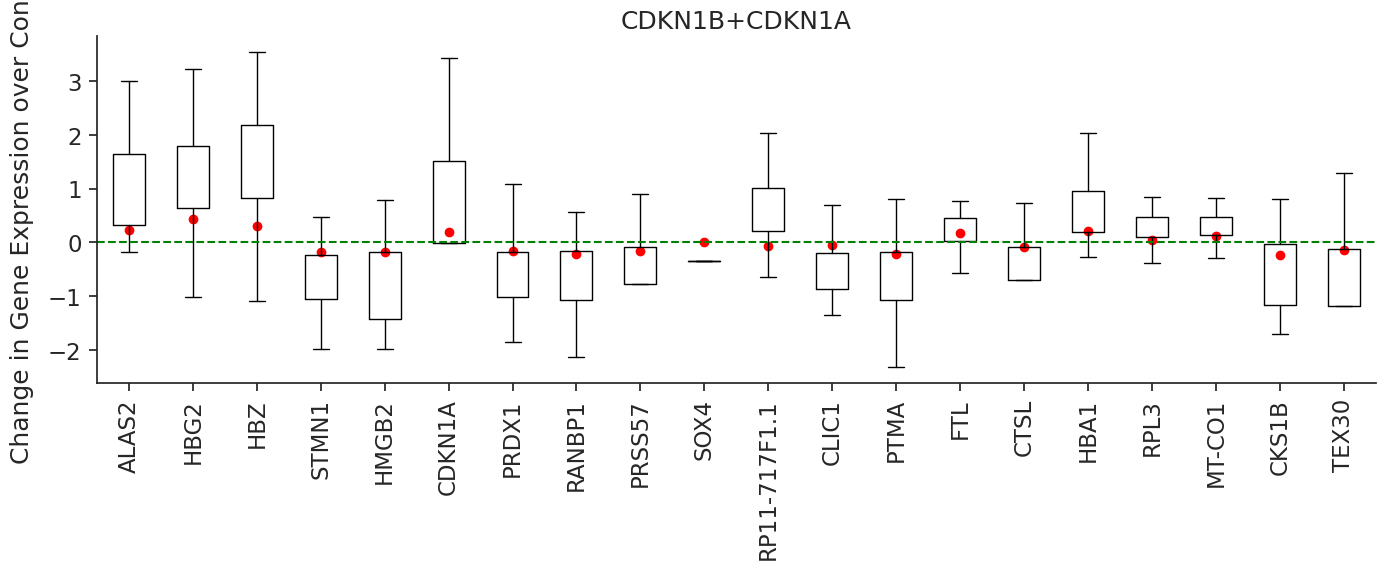

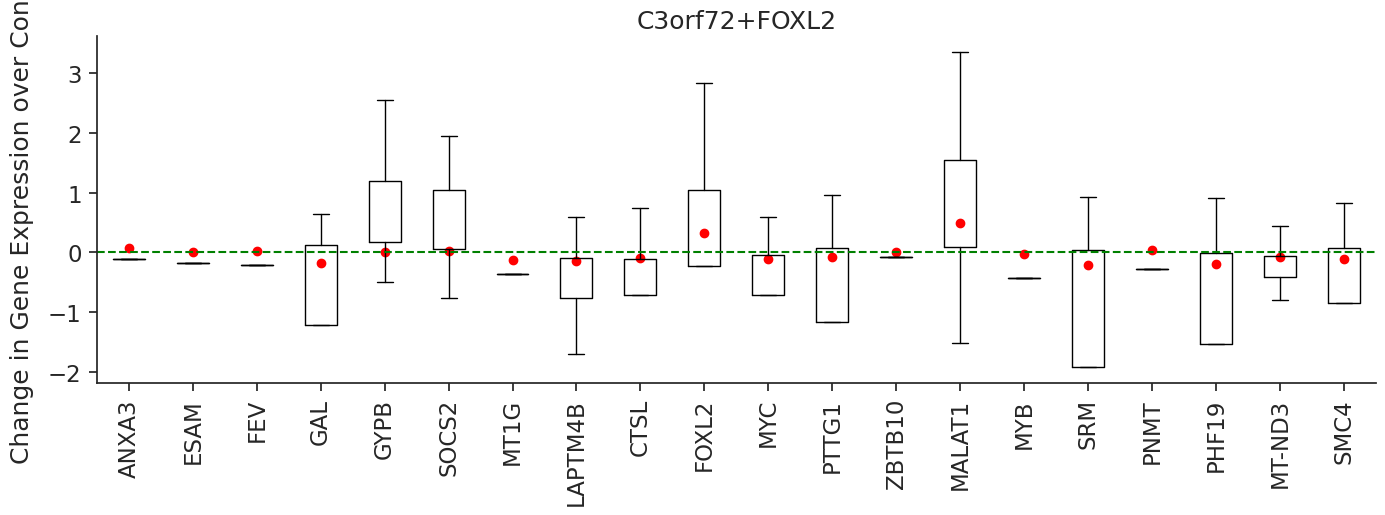

In [20]:
# predict(best_model, [["FEV"], ["FEV", "SAMD11"]])
# best_model = model
for p in perts_to_plot:
    plot_perturbation(best_model, p, pool_size=10, save_file=f"{save_dir}/{p}.png")

In [13]:
test_loader = pert_data.dataloader["test_loader"]
test_res = eval_perturb(test_loader, best_model, device)
# test_metrics, test_pert_res = compute_metrics(test_res)
test_metrics = compute_perturbation_metrics(
    test_res, pert_data.adata[pert_data.adata.obs["condition"] == "ctrl"]
)
print(test_metrics)

# save the dicts in json
with open(f"{save_dir}/test_metrics.json", "w") as f:
    json.dump(test_metrics, f)
# with open(f"{save_dir}/test_pert_res.json", "w") as f:
#     json.dump(test_pert_res, f)

deeper_res = deeper_analysis(pert_data.adata, test_res)
non_dropout_res = non_dropout_analysis(pert_data.adata, test_res)

metrics = ["pearson_delta", "pearson_delta_de"]
metrics_non_dropout = [
    "pearson_delta_top20_de_non_dropout",
    "pearson_top20_de_non_dropout",
]
subgroup_analysis = {}
for name in pert_data.subgroup["test_subgroup"].keys():
    subgroup_analysis[name] = {}
    for m in metrics:
        subgroup_analysis[name][m] = []

    for m in metrics_non_dropout:
        subgroup_analysis[name][m] = []

for name, pert_list in pert_data.subgroup["test_subgroup"].items():
    for pert in pert_list:
        for m in metrics:
            subgroup_analysis[name][m].append(deeper_res[pert][m])

        for m in metrics_non_dropout:
            subgroup_analysis[name][m].append(non_dropout_res[pert][m])

for name, result in subgroup_analysis.items():
    for m in result.keys():
        mean_value = np.mean(subgroup_analysis[name][m])
        logger.info("test_" + name + "_" + m + ": " + str(mean_value))


{'pearson': 0.9904118130127787, 'pearson_de': 0.9794049791961658, 'pearson_delta': 0.6418570216674039, 'pearson_de_delta': 0.7973933739812668}
scGPT - INFO - test_combo_seen0_pearson_delta: nan
scGPT - INFO - test_combo_seen0_pearson_delta_de: nan
scGPT - INFO - test_combo_seen0_pearson_delta_top20_de_non_dropout: nan
scGPT - INFO - test_combo_seen0_pearson_top20_de_non_dropout: nan
scGPT - INFO - test_combo_seen1_pearson_delta: nan
scGPT - INFO - test_combo_seen1_pearson_delta_de: nan
scGPT - INFO - test_combo_seen1_pearson_delta_top20_de_non_dropout: nan
scGPT - INFO - test_combo_seen1_pearson_top20_de_non_dropout: nan
scGPT - INFO - test_combo_seen2_pearson_delta: nan
scGPT - INFO - test_combo_seen2_pearson_delta_de: nan
scGPT - INFO - test_combo_seen2_pearson_delta_top20_de_non_dropout: nan
scGPT - INFO - test_combo_seen2_pearson_top20_de_non_dropout: nan
scGPT - INFO - test_unseen_single_pearson_delta: 0.6418570216674039
scGPT - INFO - test_unseen_single_pearson_delta_de: 0.797393